<a href="https://colab.research.google.com/github/lymoelopez/filipino-fake-news-detection/blob/main/fakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [194]:
import numpy as np
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from google.colab import files
import io
import matplotlib.pyplot as plt

import re
import string

# Data Preparation




In [ ]:
# import from local files
uploaded = files.upload()

Saving full.csv to full.csv


In [ ]:
#Read dataset
df = pd.read_csv(io.BytesIO(uploaded['full.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#Get shape
df.shape

# output first 5 records
df.head()  

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [ ]:
# Get dataFrame (df) labels
labels=df.label
labels.head() # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7f680207e390>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

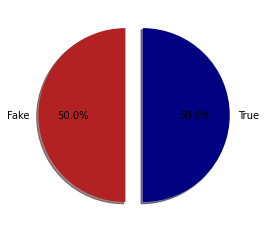

In [ ]:
# dataset distribution [pie chart]
fakeNewsCategory = pd.get_dummies(df.label)[1]  # 1 = fake, 0 = real
fakeNewsSize = fakeNewsCategory.sum()
realNewsSize = len(fakeNewsCategory)- fakeNewsSize

datasetSize = [fakeNewsSize, realNewsSize]

plt.pie(datasetSize,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Data Augmentation (w/ Back Translation)

In [ ]:
# import from local files
uploadedBT = files.upload()

Saving backTranslated.csv to backTranslated (1).csv


In [ ]:
#Read dataset
dfBT = pd.read_csv(io.BytesIO(uploadedBT['backTranslated.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#Get shape
dfBT.shape

# output first 5 records
dfBT.head()  

,label,article
0,0,"Ayon sa TheWrap.com, si Krupa, 35, ay nagsampa..."
1,0,Kilala rin ang mang-aawit sa pagkumpas ng kany...
2,0,"BLANTYRE, Malawi (AP) -- Naglakbay si Madonna ..."
3,0,"Kasama sa programa ang panalangin, bulaklak a..."
4,0,Linisin ang Friendship Department dahil bibis...


In [ ]:
# Get dataFrame (df) labels
labelsBT=dfBT.label
labelsBT.head() # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7f6802026650>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

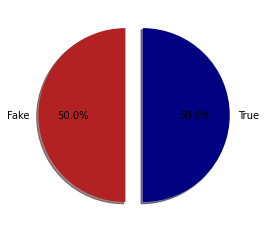

In [ ]:
# dataset distribution [pie chart]
fakeNewsCategoryBT = pd.get_dummies(dfBT.label)[1]  # 1 = fake, 0 = real
fakeNewsSizeBT = fakeNewsCategoryBT.sum()
realNewsSizeBT = len(fakeNewsCategoryBT)- fakeNewsSizeBT

datasetSizeBT = [fakeNewsSizeBT, realNewsSizeBT]

plt.pie(datasetSizeBT,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Preprocessing

In [212]:
def removeCharactersAndLowercase(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

df['article'] = df['article'].apply(removeCharactersAndLowercase)
dfBT['article'] = dfBT['article'].apply(removeCharactersAndLowercase)

#### Byte Pair encoding

In [228]:
!pip install bpemb -force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: orce-reinstall
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [230]:
from bpemb import BPEmb
bpemb_tl = BPEmb(lang="tl", dim=50)

downloading https://nlp.h-its.org/bpemb/tl/tl.wiki.bpe.vs10000.model


100%|██████████| 397105/397105 [00:00<00:00, 985499.02B/s]


downloading https://nlp.h-its.org/bpemb/tl/tl.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1920249/1920249 [00:00<00:00, 2725747.91B/s]


#Train-Test Split

In [213]:
# 80 - 20 train test split
x_train1,x_test,y_train1,y_test=train_test_split(df['article'], labels, test_size=0.3, random_state=7)

In [214]:
# use same random_state to split back translated dataset the same way
# we are only intrested in train split
# 80 - 20 train test split
x_trainBT,x_testBT,y_trainBT,y_testBT = train_test_split(dfBT['article'], labelsBT, test_size=0.3, random_state=7)

In [216]:
#x_train = pd.merge(x_train1, x_trainBT, right_index=True, left_index=True)
x_train = x_train1.append(x_trainBT, ignore_index = True)
y_train = y_train1.append(y_trainBT, ignore_index = True)
#print(x_train)

# Feature Extraction

In [217]:
# Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.7, min_df=5)

# Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)



# Classification Algorithms

#### Passive Agressive Classifier

In [218]:
# Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=100)
pac.fit(tfidf_train,y_train)

# Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Passive Agressive Accuracy: {round(score*100,2)}%')

Passive Agressive Accuracy: 95.22%


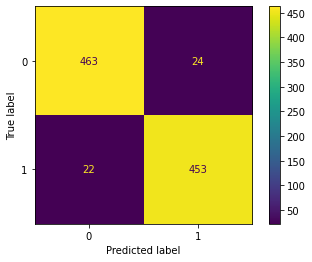

In [219]:
#Build confusion matrix
# [true negative, false positive]
# [false negative, true positive]

pac_cm = confusion_matrix(y_test,y_pred)
pac_cm_display = ConfusionMatrixDisplay(pac_cm).plot()

#### Multinomial Naive Bayes

In [220]:
MultNB = MultinomialNB()
MultNB.fit(tfidf_train,y_train)
MultNB_pred=MultNB.predict(tfidf_test)

In [221]:
score1=accuracy_score(y_test,MultNB_pred)
print(f'Multinomial Naive Bayes Accuracy: {round(score1*100,2)}%')

Multinomial Naive Bayes Accuracy: 89.6%


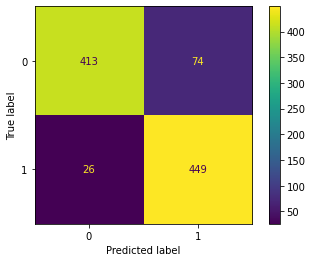

In [222]:
MultNB_cm = confusion_matrix(y_test,MultNB_pred)

MultNB_cm_display = ConfusionMatrixDisplay(MultNB_cm).plot()

#### Random Forest

In [223]:
rfc=RandomForestClassifier(n_estimators= 10, random_state= 7)
rfc.fit(tfidf_train,y_train)
rfc_pred = rfc.predict(tfidf_test)

In [224]:
score2=accuracy_score(y_test,rfc_pred)
print(f'Random Forest Accuracy: {round(score2*100,2)}%')

Random Forest Accuracy: 91.27%


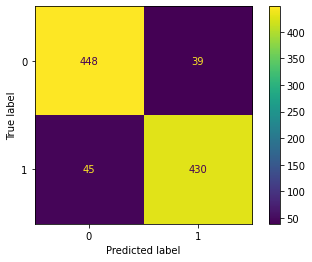

In [225]:
rfc_cm = confusion_matrix(y_test,rfc_pred)

rfc_cm_display = ConfusionMatrixDisplay(rfc_cm).plot()

#### SVM (Support Vector Classification/SVC)

In [226]:
svc = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svc.fit(tfidf_train,y_train)
svc_pred = svc.predict(tfidf_test)

In [227]:
SVCscore=accuracy_score(y_test,svc_pred)
print(f'SVC Accuracy: {round(SVCscore*100,2)}%')

SVC Accuracy: 95.32%


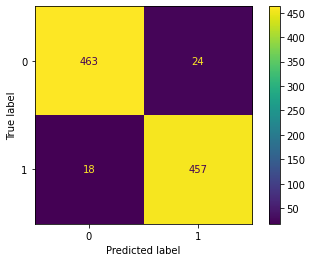

In [ ]:
svc_cm = confusion_matrix(y_test,svc_pred)

svc_cm_display = ConfusionMatrixDisplay(svc_cm).plot()

#### Logistic Regression

In [ ]:
LogReg = LogisticRegression()
LogReg.fit(tfidf_train,y_train)
LogReg_pred = LogReg.predict(tfidf_test)

In [ ]:
LogRegscore=accuracy_score(y_test,LogReg_pred)
print(f'Logistic Regresion Accuracy: {round(LogRegscore*100,2)}%')

Logistic Regresion Accuracy: 94.18%


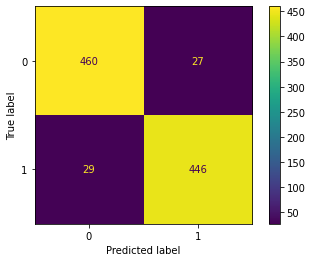

In [ ]:
LogReg_cm = confusion_matrix(y_test,LogReg_pred)

LogReg_cm_display = ConfusionMatrixDisplay(LogReg_cm).plot()

#### Stochastic Gradient Descent (SGD Classifier)

In [ ]:
sgd_clf = SGDClassifier()
sgd_clf.fit(tfidf_train,y_train)
sgd_pred = sgd_clf.predict(tfidf_test)

In [ ]:
SGDscore=accuracy_score(y_test,sgd_pred)
print(f'SGD Accuracy: {round(SGDscore*100,2)}%')

SGD Accuracy: 95.22%


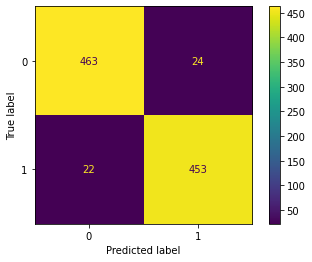

In [ ]:
sgd_cm = confusion_matrix(y_test,sgd_pred)

sgd_cm_display = ConfusionMatrixDisplay(sgd_cm).plot()

#### Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(tfidf_train,y_train)
dt_pred = dt_clf.predict(tfidf_test)

In [ ]:
DTscore=accuracy_score(y_test,dt_pred)
print(f'SGD Accuracy: {round(DTscore*100,2)}%')

SGD Accuracy: 91.16%


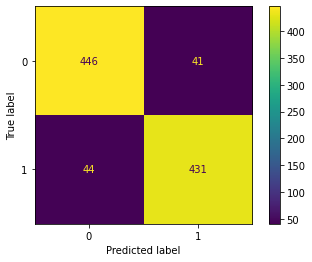

In [ ]:
dt_cm = confusion_matrix(y_test,dt_pred)

dt_cm_display = ConfusionMatrixDisplay(dt_cm).plot()

#### XGBoost

In [ ]:
xgb = xgb.XGBClassifier()
xgb.fit(tfidf_train,y_train)
xgb_pred = xgb.predict(tfidf_test)

In [ ]:
XGBscore=accuracy_score(y_test,xgb_pred)
print(f'XGBoost Accuracy: {round(XGBscore*100,2)}%')

XGBoost Accuracy: 93.97%


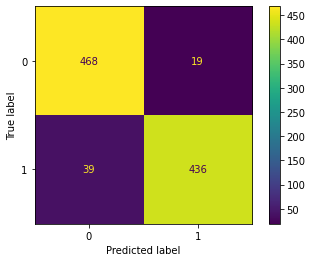

In [ ]:
xgb_cm = confusion_matrix(y_test,xgb_pred)

xgb_cm_display = ConfusionMatrixDisplay(xgb_cm).plot()

#### Extra Trees

In [ ]:
et = ExtraTreesClassifier()
et.fit(tfidf_train,y_train)
et_pred = et.predict(tfidf_test)

In [ ]:
ETscore=accuracy_score(y_test,et_pred)
print(f'Extra Trees Accuracy: {round(ETscore*100,2)}%')

Extra Trees Accuracy: 92.83%


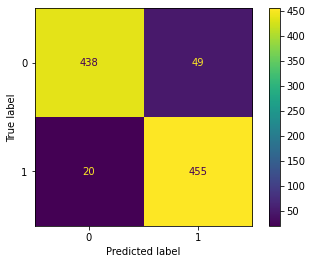

In [ ]:
et_cm = confusion_matrix(y_test,et_pred)

et_cm_display = ConfusionMatrixDisplay(et_cm).plot()

#### AdaBoost

In [ ]:
abc = AdaBoostClassifier()
abc.fit(tfidf_train,y_train)
abc_pred = abc.predict(tfidf_test)

In [ ]:
ABCscore=accuracy_score(y_test,abc_pred)
print(f'adaBoost Accuracy: {round(ABCscore*100,2)}%')

adaBoost Accuracy: 93.24%


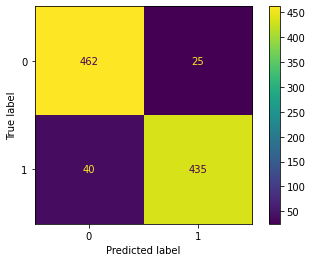

In [ ]:
abc_cm = confusion_matrix(y_test,abc_pred)

abc_cm_display = ConfusionMatrixDisplay(abc_cm).plot()

# Voting Classifier

In [ ]:
estimatorList = [('pac',pac),('MultNB',MultNB),('rfc',rfc),('svc',svc),('LogReg',LogReg),
                 ('sgd_clf',sgd_clf),('dt_clf',dt_clf),('xgb',xgb),('et',et),('abc',abc)]

Ensemb = VotingClassifier( estimators = estimatorList, voting = 'hard')
Ensemb.fit(tfidf_train,y_train)
Ensemb_pred=Ensemb.predict(tfidf_test)

In [ ]:
score4=accuracy_score(y_test,Ensemb_pred)
print(f'Ensemble Learning Accuracy: {round(score4*100,2)}%')

Ensemble Learning Accuracy: 96.15%


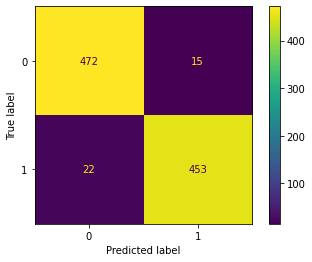

In [ ]:
Ensemb_cm = confusion_matrix(y_test,Ensemb_pred)

Encemb_cm_display = ConfusionMatrixDisplay(Ensemb_cm).plot()

# References

[1] https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

[2] https://github.com/nabi-hassan/Fake-news-Detection-using-Ensemble-Learning-/blob/master/newnote.ipynb

[3] https://towardsdatascience.com/fake-news-detection-with-machine-learning-using-python-3347d9899ad1

[4] https://jovian.ai/piero-paialunga/notebook

[5] https://youtu.be/5X27excCyXk
